<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 5.1 
# *Logistic Regression*

## Predicting Survival on the Titanic

The Titanic sank during her maiden voyage after colliding with an iceberg (April 15, 1912). Due to a commercial decision there were insufficient lifeboats, a fact that was partially responsible for the loss 1,502 out of 2,224 passengers and crew. 

The Titanic dataset incorporates many features of typical real-world problems: a mixture of continuous and discrete features, missing data, linear covariance, and an element of random chance. Predicting survival therefore involves many practical data science skills.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

%matplotlib inline

### 1. Load Data

Load the `titanic.csv` file into a DataFrame named "titanic", with index column = `PassengerId`. Display the head of the DataFrame.

In [2]:
# ANSWER
Titanic=pd.read_csv('titanic_train.csv')
Titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Why would we want to set an index column based on `PassengerId`?

ANSWER: This column is the key to training and testing our model. We use it to partition the dataset and to test the predictions of our model against known outcomes.

<a name="datadictionary"></a>
### 2. Data Dictionary 

If a data dictionary is available, it is handy to include it in the notebook for reference:

| Variable |                                 Definition | Key                                            |
|----------|-------------------------------------------:|------------------------------------------------|
| Survival | Survival                                   | 0 = No, 1 = Yes                                |
| Pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| Sex      | Sex                                        |                                                |
| Age      | Age in years                               |                                                |
| SibSp    | # of siblings / spouses aboard the Titanic |                                                |
| Parch    | # of parents / children aboard the Titanic |                                                |
| Ticket   | Ticket number                              |                                                |
| Fare     | Passenger fare                             |                                                |
| Cabin    | Cabin number                               |                                                |
| Embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |

### 2. EDA

Explore dataset. Find features to predict `Survived`. Get rid of null values. 

In [3]:
# ANSWER
Titanic.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [4]:
import cufflinks as cf
cf.go_offline()

In [5]:
Titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

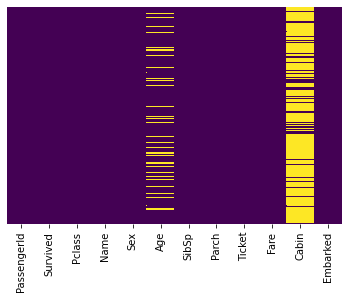

In [6]:
sns.heatmap(Titanic.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [7]:
Titanic['Fare'].iplot(kind='hist',bins=30,color='green')

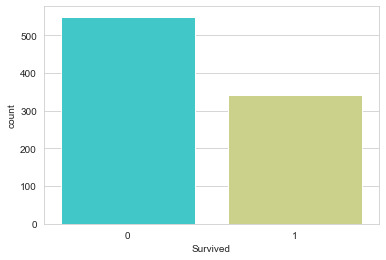

In [8]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',data=Titanic,palette='rainbow')

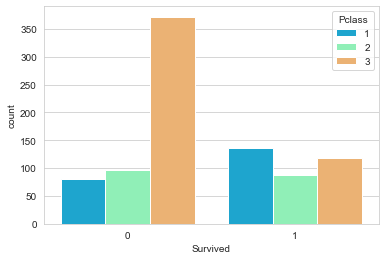

In [9]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Pclass',data=Titanic,palette='rainbow')

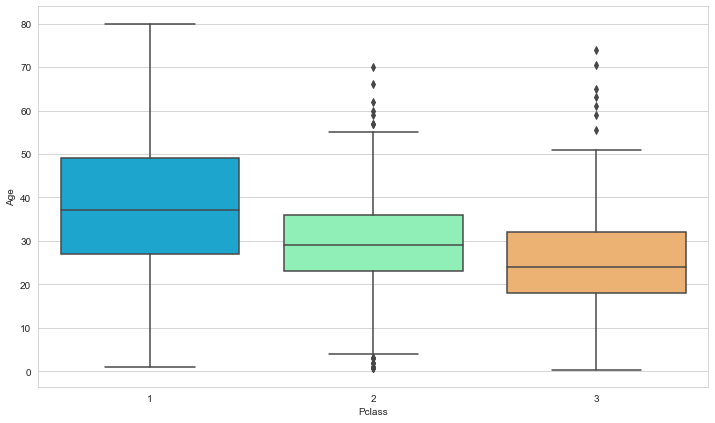

In [10]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=Titanic,palette='rainbow')

In [11]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):

        if Pclass == 1:
            return 37

        elif Pclass == 2:
            return 29

        else:
            return 24

    else:
        return Age

In [12]:
Titanic['Age'] = Titanic[['Age','Pclass']].apply(impute_age,axis=1)

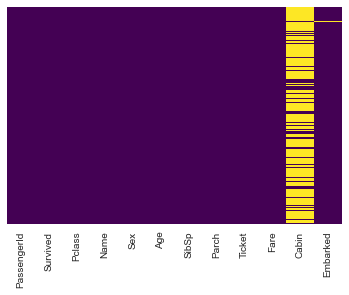

In [13]:
sns.heatmap(Titanic.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [14]:
split_Ticket = Titanic["Ticket"].str.split(" ")


In [15]:
data = split_Ticket.to_list()
names = ["Ticket_part1", "Ticket_part2","Ticket_part3"]
Ticket_df = pd.DataFrame(data, columns=names)
Ticket_df.head(100)

,Ticket_part1,Ticket_part2,Ticket_part3
0,A/5,21171,None
1,PC,17599,None
2,STON/O2.,3101282,None
3,113803,None,None
4,373450,None,None
...,...,...,...
95,374910,None,None
96,PC,17754,None
97,PC,17759,None
98,231919,None,None


In [16]:
Ticket_df.Ticket_part1.value_counts().head(50)

PC            60
C.A.          27
STON/O        12
A/5           10
W./C.          9
CA.            8
SOTON/O.Q.     8
A/5.           7
1601           7
347082         7
SOTON/OQ       7
3101295        6
347088         6
STON/O2.       6
CA             6
C              5
SC/PARIS       5
F.C.C.         5
S.O.C.         5
382652         5
4133           4
347077         4
19950          4
113781         4
SC/Paris       4
17421          4
2666           4
349909         4
LINE           4
113760         4
230080         3
35273          3
345773         3
371110         3
S.O./P.P.      3
A/4            3
A/4.           3
PP             3
110152         3
239853         3
24160          3
363291         3
13502          3
110413         3
347742         3
29106          3
248727         3
SC/AH          3
2659           2
7534           2
Name: Ticket_part1, dtype: int64

In [17]:
#Titanic[['Ticket_P1, 'Ticket_P2']] = Titanic.Ticket.str.split(" ",expand=True,)


In [18]:
#it keep only the Alphabet and excludes numbers
Titanic['Cabin']=Titanic['Cabin'].apply(lambda x : x[:1] if type(x) is str else x)
Titanic['Cabin']

0      NaN
1        C
2      NaN
3        C
4      NaN
      ... 
886    NaN
887      B
888    NaN
889      C
890    NaN
Name: Cabin, Length: 891, dtype: object

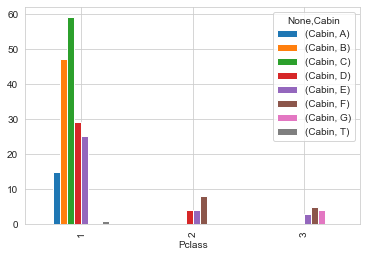

In [19]:
Titanic.groupby(by=['Pclass','Cabin']).agg({'Cabin':'count'}).unstack().plot(kind='bar')

In [20]:
#Function to replace null values of cabin which is associated with Pclasses.
def impute_cabin(cols):
    Cabin = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Cabin):

        if Pclass == 1:
            return 'ABCDE'

        elif Pclass == 2:
            return 'DEF'

        else:
            return 'FGT'

    else:
        return Cabin

In [21]:
Titanic['Cabins'] = Titanic[['Cabin','Pclass']].apply(impute_cabin,axis=1)

In [22]:
Titanic['Cabins'].value_counts().head(25)

FGT      479
DEF      168
C         59
B         47
ABCDE     40
D         33
E         32
A         15
F         13
G          4
T          1
Name: Cabins, dtype: int64

In [23]:
Titanic.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Cabins'],
      dtype='object')

In [24]:
#There are 2 cabin columns in the dataframe(Cabin and Cabins).The new column(Cabins) which s replaced with new  
#alphabet  associated with Pclass.ie Pclass 1 passenger's cabins ABCDE,Pclass2-DEF and Plass3-FGT
#Cabin column the null values are replaced with alphabet  associated with Pclass.
#ie.Pclass1 - A cabin,Pclass 2 -d and pclass3 -F

In [25]:
Titanic.head(30)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabins
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,FGT
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,FGT
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,FGT
5,6,0,3,"Moran, Mr. James",male,24.0,0,0,330877,8.4583,NaN,Q,FGT
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E,S,E
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,FGT
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,FGT
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,DEF


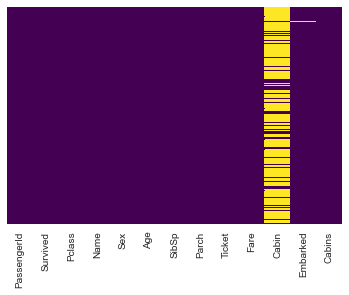

In [63]:
sns.heatmap(Titanic.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [64]:
Titanic.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
Cabins          object
dtype: object

In [65]:
#retriving null rows of Embarked column
Titanic[Titanic['Embarked'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabins
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B,NaN,B
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B,NaN,B


In [66]:
#Passengers have boarded from all the three places which ie really diffult to guess from which place they have boarded.
Titanic.groupby(by=['Pclass','Embarked']).agg({'Embarked':'count'})


Embarked
Pclass Embarked          
1      C               85
       Q                2
       S              127
2      C               17
       Q                3
       S              164
3      C               66
       Q               72
       S              353

**Here Maximum no of  Pclass 1 passengers boarded from Southampton so replacing the null values of Embarked column with 'S' because these 2 passengers belong to Pclass 1.**

In [67]:
titanic = Titanic.fillna('S')

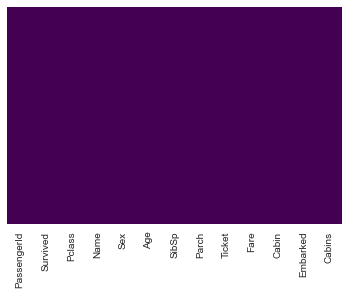

In [68]:
sns.heatmap(titanic.isnull(),yticklabels=False,cbar=False,cmap='viridis')

**Our dataset is cleaned without deleting any columns and also with no missing values**

In [69]:
titanic.columns


Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Cabins'],
      dtype='object')

### 3. Numerical Predictors Only

In [70]:
feature_cols=titanic[['PassengerId', 'Pclass','Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabins']]

#### 3.1. Set Target and Features

To begin, let's try a model based on the passenger class (`Pclass`) and parents/children features (`Parch`):

In [105]:
# ANSWER
feature_cols = ['Pclass', 'Parch']
X = titanic[feature_cols]
y = titanic['Survived']

#### 3.2 Partition

Partition the data into training and testing subsets:

- Use `random_state` = 1

In [106]:
# ANSWER
from sklearn.model_selection import train_test_split

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=1)

#### 3.3. Build Model

Prepare a model by creating an instance of the `LogisticRegression` class from the `sklearn.linear_model` library:

In [108]:
# ANSWER
# Create Model
from sklearn.linear_model import LogisticRegression

Now train it on the training data subset, using the `fit` method of the model object (Nb. by default, `fit` will print the hyperparameters of the model):

In [109]:
# ANSWER
# Fit Model

model = LogisticRegression()
model.fit(X_train,y_train)

LogisticRegression()

The computed coefficients are an array (`coef_`) stored in the 1st element of an array:

In [110]:
# ANSWER
model.coef_[0]

array([-0.8870587 ,  0.35810101])

The computed intercept (`intercept_`) is the 1st element of another array:

In [111]:
# ANSWER
model.intercept_[0]

1.3183240822377669

We can create tuples of the predictor names and coefficients like this:

In [112]:
# ANSWER
print(set(zip(feature_cols, model.coef_[0])))

{('Pclass', -0.887058696808212), ('Parch', 0.3581010063809278)}


If we want formatted output, here is a neat way to list the coefficients by predictor:

In [113]:
for col in zip(X_train.columns, model.coef_[0]):
    print('{:<10s}  {:+.06f}'.format(col[0], col[1]))  # Nb. increase 10 for longer names

Pclass      -0.887059
Parch       +0.358101


This result implies that survival declines with passenger class (i.e. 1st class is highest) but increases with the number of parents or children in a group.

Let's see how well the model fit the training data. The `accuracy_score` is the proportion of correct predictions:

In [114]:
# ANSWER

from sklearn.metrics import accuracy_score

model.score(X_train, y_train)

0.6934189406099518

What is the  `accuracy_score` for the test data?

In [115]:
# ANSWER
from sklearn.metrics import accuracy_score
score = model.score(X_test, y_test)
print('Test Accuracy Score', score)

Test Accuracy Score 0.664179104477612


What can we say aout this result?

ANSWER
- Training data shows a bit more accuracy than the testing data and its overfitted. 
- Test data shows less than 50% accuracy 

#### 3.4. Add `AGE` as Feature

Let's include `Age` in the model. As we know from our EDA, this feature has many missing values. We don't want to throw away so many rows, so we will replace `NA` values with imputed values (e.g. the overall mean age):

In [116]:
titanic['Age'].fillna(titanic.Age.mean(), inplace=True)
feature_cols = ['Pclass', 'Parch', 'Age']
X = titanic[feature_cols]

In [118]:
# Build Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

# Fit Model
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)
# Score
accuracy_score(y_test,predictions)

0.6828358208955224

Let's see where the model is going wrong by showing the Confusion Matrix:

In [119]:
# ANSWER
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, predictions))

[[132  22]
 [ 63  51]]


In [120]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.68      0.86      0.76       154
           1       0.70      0.45      0.55       114

    accuracy                           0.68       268
   macro avg       0.69      0.65      0.65       268
weighted avg       0.69      0.68      0.67       268



Nb. Here is how `confusion_matrix` arranges its output:

In [121]:
print(np.asarray([['TN', 'FP'], ['FN', 'TP']]))

[['TN' 'FP']
 ['FN' 'TP']]


Which type of error is more prevalent?

ANSWER: ...

Maybe we aren't using the right cut-off value. By default, we are predicting that `Survival` = True if the probability >= 0.5, but we could use a different threshold. The ROC curve helps us decide (as well as showing us how good our predictive model really is):

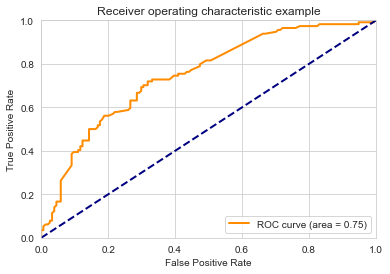

In [122]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = logmodel.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

### 4. Including Categorical Predictors

So far, we've only used numerical features for prediction. Let's convert the character features to dummy variables so we can include them in the model:

In [94]:
titanic_with_dummies = pd.get_dummies(data = titanic, columns = ['Sex', 'Embarked', 'Pclass'], 
                                      prefix = ['Sex', 'Embarked', 'Pclass'] )
titanic_with_dummies.head()

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Cabins,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,S,FGT,0,1,0,0,1,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C,C,1,0,1,0,0,1,0,0
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,S,FGT,1,0,0,0,1,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C,C,1,0,0,0,1,1,0,0
4,5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,S,FGT,0,1,0,0,1,0,0,1


So, this created a column for every possible value of every categorical variable. (A more compact approach would have been to reduce the number of dummy variables by one for each feature, so that the first vriable from each captures two possible states.)

Now that we have data on sex, embarkation port, and passenger class we can try to improve our `Age` imputation by stratifying it by the means of groups within the passenger population:

In [95]:
titanic_with_dummies['Age'] = titanic_with_dummies[["Age", "Parch", "Sex_male", "Pclass_1", "Pclass_2"]].groupby(["Parch", "Sex_male", "Pclass_1", "Pclass_2"])["Age"].transform(lambda x: x.fillna(x.mean()))
titanic_with_dummies['Age']

0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
886    27.0
887    19.0
888    24.0
889    26.0
890    32.0
Name: Age, Length: 891, dtype: float64

Now train the model using the expanded set of predictors and compute the accuracy score for the test set:

In [133]:
# ANSWER
def get_logreg_score(data, feature_cols, target_col):
    X = data[feature_cols]
    y = data[target_col]

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

    # Build Model
    logreg = LogisticRegression()

    # Fit
    logreg.fit(X_train, y_train)

    # Score
    logreg_score = logreg.score(X_test, y_test)

    # Return accuracy rate
    return logreg_score
# Set Feature Both Numerical, Categorical

Plot the ROC curve for the new model:

In [134]:
# ANSWER
target_col = 'Survived'
feature_cols = ['Parch', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Age', 'SibSp']
get_logreg_score(titanic_with_dummies, feature_cols, target_col)

0.6636771300448431

In [139]:
def plot_roc_curve(X_test, y_test):
    # Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    preds = logreg.predict_proba(X_test)[:,1]

    # Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
    fpr, tpr, _ = metrics.roc_curve(y_test, preds)

    # Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
    roc_auc = metrics.auc(fpr, tpr)

    # Plot the ROC Curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc = "lower right")
    plt.show()

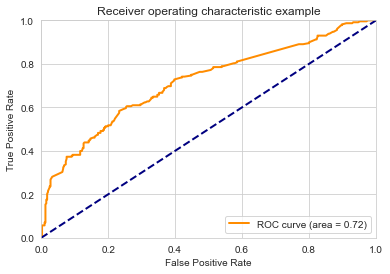

In [140]:
plot_roc_curve(X_train, y_train)

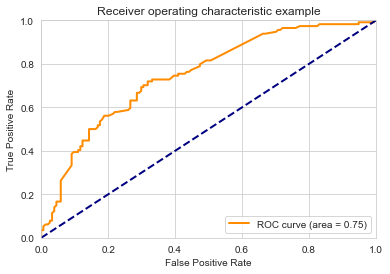

In [141]:
plot_roc_curve(X_test, y_test)

Can we improve the model by including the remaining features?

In [142]:
# ANSWER
target_col = 'Survived'
feature_cols = ['Age', 'SibSp', 'Parch', 'Fare', 
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Pclass_1', 'Pclass_2', 'Pclass_3']
get_logreg_score(titanic_with_dummies, feature_cols, target_col)

/Users/macbookpro/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.8026905829596412

## Homework

1. Remove the `random_state` parameter (if you have used), so that the data partition will be different every time, and run through the final modelling process a few times. Do the results change?

2. Use cross-validation to assess the quality of the model when overfitting is controlled. Does the accuracy improve?

3. Look at the `fpr` & `tpr` vectors for the best model.

#### 2.Use cross-validation to assess the quality of the model when overfitting is controlled. Does the accuracy improve?

In [152]:
from sklearn.model_selection import cross_val_score
target_col = 'Survived'
feature_cols = ['Age', 'SibSp', 'Parch', 'Fare', 
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Pclass_1', 'Pclass_2', 'Pclass_3']
logreg = LogisticRegression()
scores = cross_val_score(logreg, titanic_with_dummies[feature_cols], titanic_with_dummies[target_col], cv=5)
scores.mean()

/Users/macbookpro/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/macbookpro/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/m

0.7991212102190698

**3. Look at the `fpr` & `tpr` vectors for the best model.**

In [162]:
# Build Model
logreg = LogisticRegression()

# Fit
logreg.fit(X_train, y_train)

# Predict
prediction = logreg.predict(X_test)

# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(y_test, prediction)
print(confusion)

[[132  22]
 [ 63  51]]


In [159]:
# use float to perform true division, not integer division
print((TP + TN) / float(TP + TN + FP + FN))
print(metrics.accuracy_score(y_test, prediction))

0.6828358208955224
0.6828358208955224


In [160]:
classification_error = (FP + FN) / float(TP + TN + FP + FN)
print(classification_error)
print(1 - metrics.accuracy_score(y_test, prediction))

0.31716417910447764
0.3171641791044776




---



---



> > > > > > > > > © 2019 Institute of Data


---



---



